Using Lama's set of features

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import LabelEncoder
from imblearn.over_sampling import SMOTE  
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [ ]:
output_folder = "/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/RF_first_try/features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

In [ ]:
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')

In [ ]:
features_df = features_df.dropna()

In [ ]:
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1)
print(X)

y = features_df['Sleep_stage']

In [ ]:
if "Gender" in X.columns:
    le = LabelEncoder()
    X["Gender"] = le.fit_transform(X["Gender"])  # Converts 'Female' -> 0, 'Male' -> 1

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_best = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

rf_best.fit(X_train, y_train)

In [ ]:
y_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_pred))

Code

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:04:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.71      0.69      4816
           2       0.77      0.81      0.79      4817
           R       0.79      0.81      0.80      4839
           W       0.79      0.69      0.73      4842

    accuracy                           0.75     19314
   macro avg       0.76      0.75      0.75     19314
weighted avg       0.76      0.75      0.75     19314



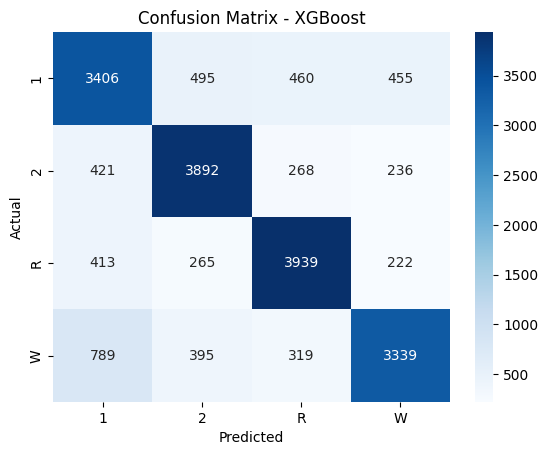

In [2]:
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all feature CSVs ===
output_folder = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\New folder\features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

# === Preprocessing ===
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')
features_df = features_df.dropna()

# === Split Features and Labels ===
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1)
y = features_df['Sleep_stage']

# === Encode Gender if present ===
if "Gender" in X.columns:
    gender_le = LabelEncoder()
    X["Gender"] = gender_le.fit_transform(X["Gender"])  # Female -> 0, Male -> 1

# === Encode Labels (y) ===
label_le = LabelEncoder()
y = label_le.fit_transform(y)

# === Resample with SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# === Train XGBoost Classifier ===
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=200,
    max_depth=None,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=1
)

xgb_model.fit(X_train, y_train)

# === Evaluate ===
y_pred = xgb_model.predict(X_test)
y_pred_labels = label_le.inverse_transform(y_pred)
y_test_labels = label_le.inverse_transform(y_test)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

# === Confusion Matrix Plot ===
conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=label_le.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_le.classes_, yticklabels=label_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [3]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, None],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid=param_grid,
    scoring='f1_weighted',  # You can also try 'accuracy'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(label_le.inverse_transform(y_test), label_le.inverse_transform(y_pred)))


Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:09:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.72      0.70      4816
           2       0.79      0.82      0.80      4817
           R       0.80      0.83      0.81      4839
           W       0.80      0.70      0.75      4842

    accuracy                           0.77     19314
   macro avg       0.77      0.77      0.77     19314
weighted avg       0.77      0.77      0.77     19314



In [14]:
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all feature CSVs ===
output_folder = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\New folder\features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

# === Preprocessing ===
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')
features_df = features_df.dropna()

# === Split Features and Labels ===
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1)
y = features_df['Sleep_stage']

# === Encode Gender if present ===
if "Gender" in X.columns:
    gender_le = LabelEncoder()
    X["Gender"] = gender_le.fit_transform(X["Gender"])  # Female -> 0, Male -> 1

# === Encode Labels (y) ===
label_le = LabelEncoder()
y = label_le.fit_transform(y)

# === Resample with SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# === Model Hyperparameters and Cross-Validation Setup ===
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.05],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1],
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [0, 1, 2]  # L2 regularization
}

# Use Stratified K-Fold Cross-Validation to evaluate model
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(f1_score, average='weighted')

# === Custom GridSearchCV Callback ===
class CustomGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, cv, scoring, n_jobs, verbose):
        super().__init__(estimator, param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=verbose)
        self.best_accuracy_so_far = 0
        self.tried_combinations = 0
    
    def _fit_and_score(self, *args, **kwargs):
        # Call the original method
        results = super()._fit_and_score(*args, **kwargs)
        
        # Increment the number of tried combinations
        self.tried_combinations += 1
        
        # Check if the best score has improved
        if self.best_score_ > self.best_accuracy_so_far:
            self.best_accuracy_so_far = self.best_score_
        
        # Print the best accuracy every 100 tries
        print(f"After {self.tried_combinations} combinations, best accuracy so far: {self.best_accuracy_so_far:.4f}")
        
        return results

# === GridSearchCV with Stratified K-Fold Cross Validation ===
grid_search = CustomGridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        scale_pos_weight=1.5  # You can adjust this depending on class imbalance
    ),
    param_grid=param_grid,
    cv=skf,
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# === Best Model from GridSearchCV ===
best_model = grid_search.best_estimator_

# === Early Stopping to Prevent Overfitting ===
best_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(X_test, y_test)], verbose=True)

# === Model Evaluation ===
y_pred = best_model.predict(X_test)

# === Classification Report ===
y_pred_labels = label_le.inverse_transform(y_pred)
y_test_labels = label_le.inverse_transform(y_test)
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

# === Confusion Matrix Plot ===
conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=label_le.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_le.classes_, yticklabels=label_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# === AUC-ROC Score ===
auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')
print("AUC-ROC Score:", auc_score)


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


KeyboardInterrupt: 

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:40:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.72      0.70      4816
           2       0.79      0.82      0.80      4817
           R       0.80      0.82      0.81      4839
           W       0.79      0.70      0.74      4842

    accuracy                           0.76     19314
   macro avg       0.77      0.76      0.76     19314
weighted avg       0.77      0.76      0.76     19314



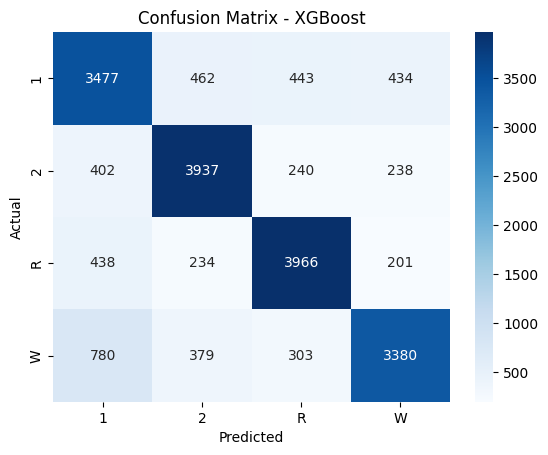

AUC-ROC Score: 0.9321652402732912


In [11]:
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all feature CSVs ===
output_folder = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\New folder\features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

# === Preprocessing ===
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')
features_df = features_df.dropna()

# === Split Features and Labels ===
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1)
y = features_df['Sleep_stage']

# === Encode Gender if present ===
if "Gender" in X.columns:
    gender_le = LabelEncoder()
    X["Gender"] = gender_le.fit_transform(X["Gender"])  # Female -> 0, Male -> 1

# === Encode Labels (y) ===
label_le = LabelEncoder()
y = label_le.fit_transform(y)

# === Resample with SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',  # Keep eval metric here instead
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    scale_pos_weight=1.5
)

xgb.fit(X_train, y_train, verbose=True)

# === Model Evaluation ===
y_pred = xgb.predict(X_test)

y_pred_labels = label_le.inverse_transform(y_pred)
y_test_labels = label_le.inverse_transform(y_test)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=label_le.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_le.classes_, yticklabels=label_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

auc_score = roc_auc_score(y_test, xgb.predict_proba(X_test), multi_class='ovr')
print("AUC-ROC Score:", auc_score)


In [16]:
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

# === Load all feature CSVs ===
output_folder = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\New folder\features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

# === Preprocessing ===
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')
features_df = features_df.dropna()

# === Split Features and Labels ===
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1)
y = features_df['Sleep_stage']

# === Encode Gender if present ===
if "Gender" in X.columns:
    gender_le = LabelEncoder()
    X["Gender"] = gender_le.fit_transform(X["Gender"])  # Female -> 0, Male -> 1

# === Encode Labels (y) ===
label_le = LabelEncoder()
y = label_le.fit_transform(y)

# === Resample with SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# === Model Hyperparameters and CV Setup ===
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 3)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scorer(f1_score, average='weighted')

# === RandomizedSearchCV ===
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    scale_pos_weight=1.5,
    #tree_method='gpu_hist',         # ✅ Use GPU if available
    #predictor='gpu_predictor',
    n_jobs=1                        # ✅ Prevent multithreaded overload inside model
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # You can adjust this depending on compute time
    scoring=scoring,
    n_jobs=-1,
    cv=skf,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

# === Best Model from RandomizedSearchCV ===
best_model = random_search.best_estimator_

# === Early Stopping to Prevent Overfitting ===
best_model.fit(X_train, y_train,
               early_stopping_rounds=10,
               eval_metric="mlogloss",
               eval_set=[(X_test, y_test)],
               verbose=True)

# === Model Evaluation ===
y_pred = best_model.predict(X_test)
y_pred_labels = label_le.inverse_transform(y_pred)
y_test_labels = label_le.inverse_transform(y_test)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

# === Confusion Matrix Plot ===
conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=label_le.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_le.classes_, yticklabels=label_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# === AUC-ROC Score ===
auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')
print("AUC-ROC Score:", auc_score)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:14:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

with prev_stage

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22988\1709350238.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['prev_stage'] = features_df['prev_stage'].fillna(method='bfill')  # fill first row of each group
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:50:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
               precision    recall  f1-score   support

           1       0.82      0.76      0.79      2157
           2       0.85      0.94      0.89      2156
           R       0.87      0.93      0.90      2228
           W       0.88      0.79      0.83      2216

    accuracy                           0.85      8757
   macro avg       0.85      0.85      0.85      8757
weighted avg       0.85      0.85      0.85      8757



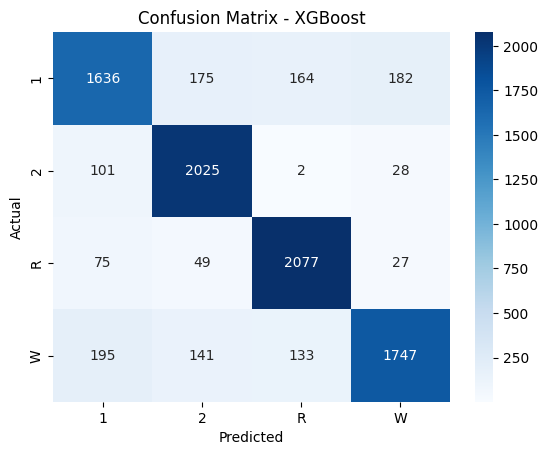

In [ ]:
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all feature CSVs ===
output_folder = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\New folder\features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

# === Preprocessing ===
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')
features_df = features_df.dropna()

# === Add 'prev_stage' feature (must sort by time for each patient) ===
# Convert datetime if needed
if not pd.api.types.is_datetime64_any_dtype(features_df['Date_E4_synced']):
    features_df['Date_E4_synced'] = pd.to_datetime(features_df['Date_E4_synced'], errors='coerce')

features_df = features_df.sort_values(by=['Patient_ID', 'Date_E4_synced'])

# Fill in 'prev_stage' by shifting within each patient
features_df['prev_stage'] = features_df.groupby('Patient_ID')['Sleep_stage'].shift(1)
features_df['prev_stage'] = features_df['prev_stage'].fillna(method='bfill')  # fill first row of each group
features_df = features_df.dropna()

# === Encode prev_stage before splitting ===
prev_stage_le = LabelEncoder()
features_df['prev_stage'] = prev_stage_le.fit_transform(features_df['prev_stage'])

# === Split Features and Labels ===
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1)
y = features_df['Sleep_stage']

# === Encode Gender if present ===
if "Gender" in X.columns:
    gender_le = LabelEncoder()
    X["Gender"] = gender_le.fit_transform(X["Gender"])

# === Encode Labels (y) ===
label_le = LabelEncoder()
y = label_le.fit_transform(y)

# === Resample with SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# === Train XGBoost Classifier ===
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=200,
    max_depth=None,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=1
)

xgb_model.fit(X_train, y_train)

# === Evaluate ===
y_pred = xgb_model.predict(X_test)
y_pred_labels = label_le.inverse_transform(y_pred)
y_test_labels = label_le.inverse_transform(y_test)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

# === Confusion Matrix Plot ===
conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=label_le.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_le.classes_, yticklabels=label_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, None],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid=param_grid,
    scoring='f1_weighted',  # You can also try 'accuracy'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(label_le.inverse_transform(y_test), label_le.inverse_transform(y_pred)))


Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:53:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           1       0.83      0.78      0.80      2157
           2       0.85      0.94      0.89      2156
           R       0.88      0.93      0.91      2228
           W       0.89      0.80      0.84      2216

    accuracy                           0.86      8757
   macro avg       0.86      0.86      0.86      8757
weighted avg       0.86      0.86      0.86      8757



Using normalized features

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13396\2227677299.py:37: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['prev_stage'] = features_df['prev_stage'].fillna(method='bfill')
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:43:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.78      0.81      2157
           2       0.83      0.92      0.87      2156
           R       0.91      0.96      0.93      2228
           W       0.90      0.81      0.85      2216

    accuracy                           0.87      8757
   macro avg       0.87      0.87      0.87      8757
weighted avg       0.87      0.87      0.87      8757



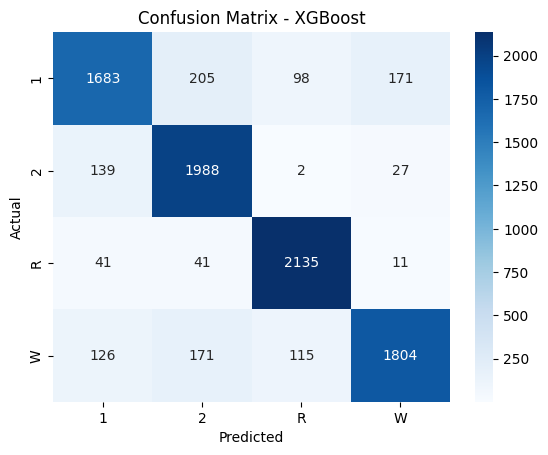

In [16]:
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all feature CSVs ===
output_folder = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\New folder\features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

# === Preprocessing ===
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')
features_df = features_df.dropna()

# Convert datetime if needed
if not pd.api.types.is_datetime64_any_dtype(features_df['Date_E4_synced']):
    features_df['Date_E4_synced'] = pd.to_datetime(features_df['Date_E4_synced'], errors='coerce')

# === Add 'prev_stage' feature (must sort by time for each patient) ===
features_df = features_df.sort_values(by=['Patient_ID', 'Date_E4_synced'])
features_df['prev_stage'] = features_df.groupby('Patient_ID')['Sleep_stage'].shift(1)
features_df['prev_stage'] = features_df['prev_stage'].fillna(method='bfill')
features_df = features_df.dropna()

# Encode 'prev_stage'
prev_stage_le = LabelEncoder()
features_df['prev_stage'] = prev_stage_le.fit_transform(features_df['prev_stage'])

# === Split Features and Labels ===
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1)
y = features_df['Sleep_stage']

# Encode 'Gender' if present
if "Gender" in X.columns:
    gender_le = LabelEncoder()
    X["Gender"] = gender_le.fit_transform(X["Gender"])

# Encode Labels (y)
label_le = LabelEncoder()
y = label_le.fit_transform(y)

# === Normalize Numerical Features ===
cols_to_normalize = ['Mode', 'Median', 'MaxAbs', 'LineLength', '10thQuantile',
                     '75thQuantile', 'NonLinearEnergy', 'SVD_Entropy', 'ShannonEntropy',
                     'Average EDA per epoch', 'EDR_count', 'time_since_storm_start',
                     'time_since_last_storm', 'ACC_mean', 'BVP_mean', 'HR_mean', 'TEMP_mean']

scaler = StandardScaler()
X[cols_to_normalize] = scaler.fit_transform(X[cols_to_normalize])

# === Resample with SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# === Train XGBoost Classifier ===
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=200,
    max_depth=None,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=1
)

xgb_model.fit(X_train, y_train)

# === Evaluate ===
y_pred = xgb_model.predict(X_test)
y_pred_labels = label_le.inverse_transform(y_pred)
y_test_labels = label_le.inverse_transform(y_test)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

# === Confusion Matrix Plot ===
conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=label_le.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_le.classes_, yticklabels=label_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


Total inference time for 8757 samples: 0.0275 seconds
Average inference time per sample: 0.0031 milliseconds

Inference time for different batch sizes:
Batch size: 1, Total time: 0.0030 sec, Avg per sample: 2.9979 ms
Batch size: 10, Total time: 0.0030 sec, Avg per sample: 0.3000 ms
Batch size: 100, Total time: 0.0040 sec, Avg per sample: 0.0400 ms
Batch size: 1000, Total time: 0.0050 sec, Avg per sample: 0.0050 ms


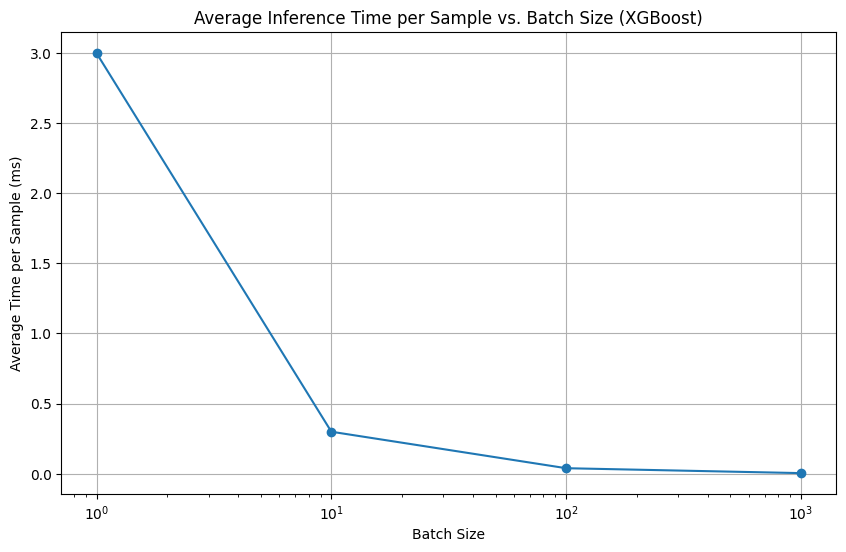

In [17]:
import time
import matplotlib.pyplot as plt

# === Measure inference time for the full X_test ===
start_time = time.time()

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

end_time = time.time()
total_time = end_time - start_time
avg_inference_time = (total_time / len(X_test)) * 1000  # Convert to milliseconds

print(f"Total inference time for {len(X_test)} samples: {total_time:.4f} seconds")
print(f"Average inference time per sample: {avg_inference_time:.4f} milliseconds")

# === Measure inference time for different batch sizes ===
batch_sizes = [1, 10, 100, 1000]
results = []

for batch_size in batch_sizes:
    if batch_size <= len(X_test):
        # Take a subset of the test data
        X_batch = X_test.iloc[:batch_size]
        
        # Time the prediction
        start_time = time.time()
        xgb_model.predict(X_batch)
        end_time = time.time()
        
        batch_time = end_time - start_time
        avg_time_per_sample = (batch_time / batch_size) * 1000  # Convert to milliseconds
        
        results.append({
            'batch_size': batch_size,
            'total_time': batch_time,
            'avg_time_per_sample': avg_time_per_sample
        })

# === Display results ===
print("\nInference time for different batch sizes:")
for result in results:
    print(f"Batch size: {result['batch_size']}, Total time: {result['total_time']:.4f} sec, "
          f"Avg per sample: {result['avg_time_per_sample']:.4f} ms")

# === Plot the results ===
plt.figure(figsize=(10, 6))
plt.plot([r['batch_size'] for r in results], [r['avg_time_per_sample'] for r in results], 'o-')
plt.title('Average Inference Time per Sample vs. Batch Size (XGBoost)')
plt.xlabel('Batch Size')
plt.ylabel('Average Time per Sample (ms)')
plt.xscale('log')  # Use logarithmic scale for batch size
plt.grid(True)
plt.show()


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, None],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid=param_grid,
    scoring='f1_weighted',  # You can also try 'accuracy'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(label_le.inverse_transform(y_test), label_le.inverse_transform(y_pred)))


Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.81      0.83      2157
           2       0.84      0.92      0.88      2156
           R       0.91      0.96      0.93      2228
           W       0.91      0.82      0.86      2216

    accuracy                           0.88      8757
   macro avg       0.88      0.88      0.88      8757
weighted avg       0.88      0.88      0.88      8757



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22988\2854055923.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')


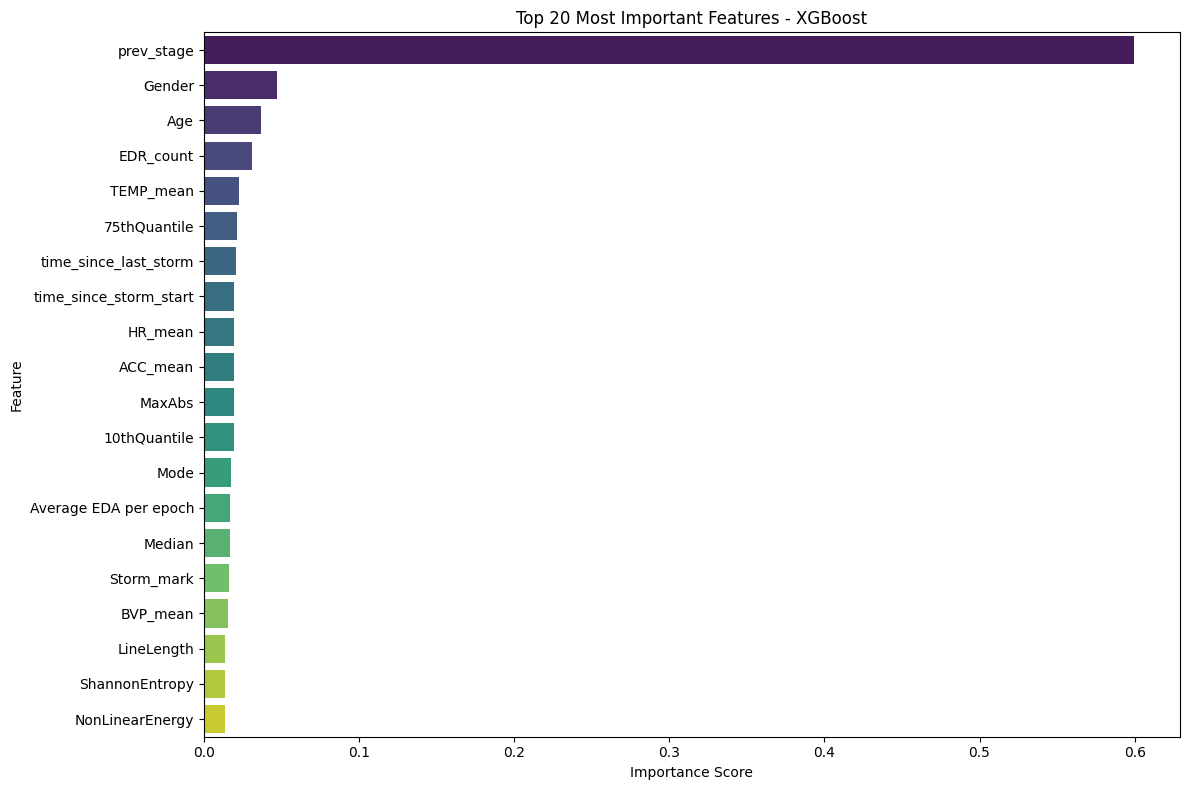

In [21]:
# === Feature Importance Plot ===
importances = xgb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Most Important Features - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


First and second derivatives added

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13396\976223020.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['prev_stage'] = features_df['prev_stage'].fillna(method='bfill')
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:58:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.78      0.81      2157
           2       0.83      0.92      0.87      2156
           R       0.91      0.96      0.93      2228
           W       0.90      0.81      0.85      2216

    accuracy                           0.87      8757
   macro avg       0.87      0.87      0.87      8757
weighted avg       0.87      0.87      0.87      8757



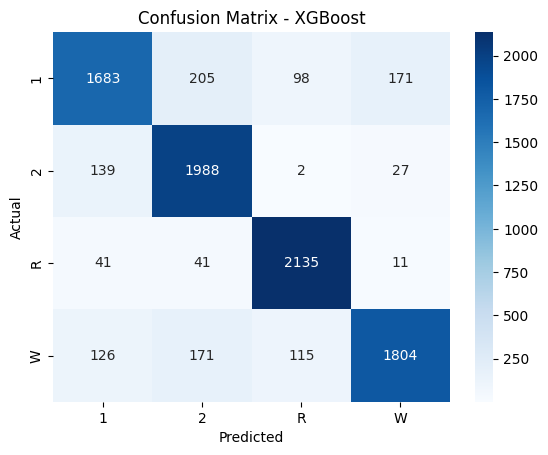

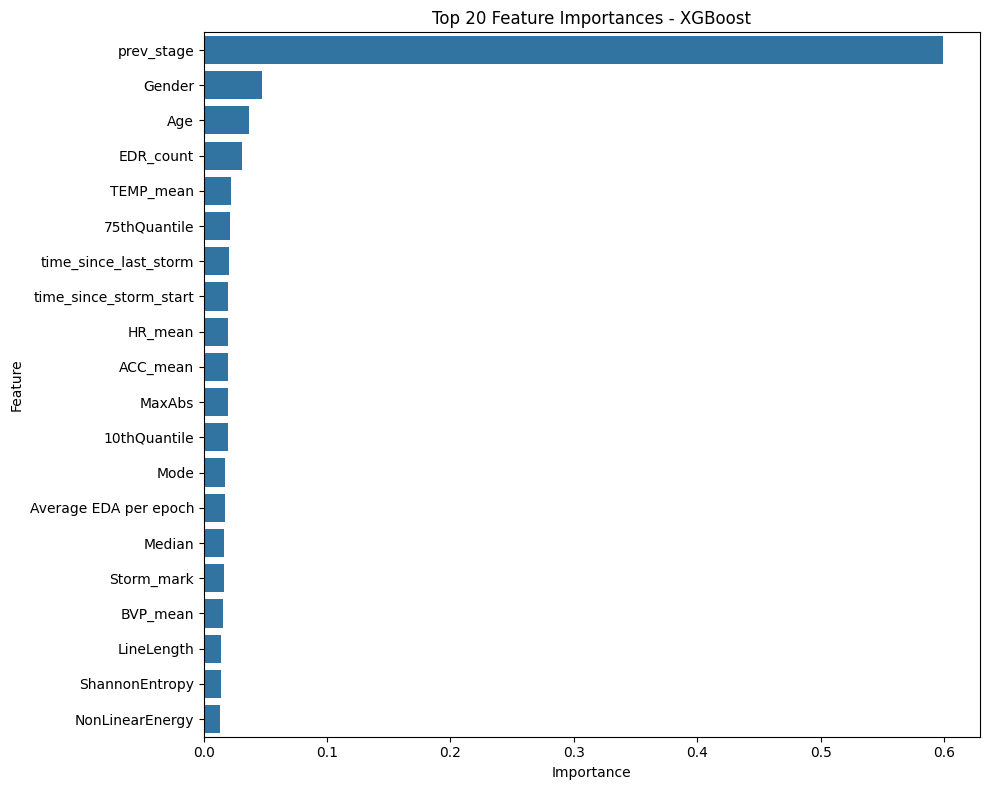

In [10]:
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all feature CSVs ===
output_folder = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\New folder\features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

# === Preprocessing ===
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')
features_df = features_df.dropna()

# Convert datetime if needed
if not pd.api.types.is_datetime64_any_dtype(features_df['Date_E4_synced']):
    features_df['Date_E4_synced'] = pd.to_datetime(features_df['Date_E4_synced'], errors='coerce')

# === Sort by patient and time ===
features_df = features_df.sort_values(by=['Patient_ID', 'Date_E4_synced'])

# === Add 'prev_stage' feature ===
features_df['prev_stage'] = features_df.groupby('Patient_ID')['Sleep_stage'].shift(1)
features_df['prev_stage'] = features_df['prev_stage'].fillna(method='bfill')

# Drop rows with new NaNs
features_df = features_df.dropna()

# Encode 'prev_stage'
prev_stage_le = LabelEncoder()
features_df['prev_stage'] = prev_stage_le.fit_transform(features_df['prev_stage'])

# === Split Features and Labels ===
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1, errors='ignore')
y = features_df['Sleep_stage']

# Encode 'Gender' if present
if "Gender" in X.columns:
    gender_le = LabelEncoder()
    X["Gender"] = gender_le.fit_transform(X["Gender"])

# Encode Labels (y)
label_le = LabelEncoder()
y = label_le.fit_transform(y)

# === Normalize Numerical Features ===
cols_to_normalize = ['Mode', 'Median', 'MaxAbs', 'LineLength', '10thQuantile',
                     '75thQuantile', 'NonLinearEnergy', 'SVD_Entropy', 'ShannonEntropy',
                     'Average EDA per epoch', 'EDR_count', 'time_since_storm_start',
                     'time_since_last_storm', 'ACC_mean', 'BVP_mean', 'HR_mean', 'TEMP_mean']

scaler = StandardScaler()
X[cols_to_normalize] = scaler.fit_transform(X[cols_to_normalize])

# === Resample with SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# === Train XGBoost Classifier ===
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=200,
    max_depth=None,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=1
)

xgb_model.fit(X_train, y_train)

# === Evaluate ===
y_pred = xgb_model.predict(X_test)
y_pred_labels = label_le.inverse_transform(y_pred)
y_test_labels = label_le.inverse_transform(y_test)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

# === Confusion Matrix Plot ===
conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=label_le.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_le.classes_, yticklabels=label_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# === Feature Importance Plot ===
importances = xgb_model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
plt.title('Top 20 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()


In [4]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Use Stratified K-Fold to preserve class distribution
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a slightly richer hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],  # Don't include None here; max_depth=None is not ideal in tuning
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'min_child_weight': [1, 5, 10]  # Important for controlling overfitting
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        objective='multi:softprob',  # better for probability output
        random_state=42
    ),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

print("\nBest Parameters found:")
print(grid_search.best_params_)

# Predict and evaluate
y_pred = best_model.predict(X_test)
print("\nClassification Report (after GridSearch tuning):\n")
print(classification_report(label_le.inverse_transform(y_test), label_le.inverse_transform(y_pred), digits=4))


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


KeyboardInterrupt: 

In [14]:
from sklearn.model_selection import ParameterSampler, StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Target early stopping F1 score (rounded to 0.89)
target_f1 = 0.89

# CV strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter distributions
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'min_child_weight': [1, 3, 5, 7, 10]
}

# How many random combinations you want to try
n_iter_search = 30

# Sample random parameter combinations
all_param_combinations = list(ParameterSampler(param_distributions=param_dist, n_iter=n_iter_search, random_state=42))

best_score = 0
best_params = None
best_model = None

for params in all_param_combinations:
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        objective='multi:softprob',
        random_state=42,
        **params
    )
    
    cv_scores = []
    for train_idx, val_idx in cv_strategy.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)
        score = f1_score(y_val, y_pred_val, average='weighted')
        cv_scores.append(score)
    
    mean_cv_score = np.mean(cv_scores)
    print(f"Params: {params} --> F1-weighted CV Score: {mean_cv_score:.4f}")
    
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_params = params
        best_model = model
    
    # EARLY STOP if performance exceeds target
    if round(mean_cv_score, 2) >= target_f1 and round(mean_cv_score, 2) <= target_f1+0.01:
        print("\n🎯 Early stopping criteria met! Stopping Randomized Search.\n")
        break

# After search
print("\nBest Parameters found:")
print(best_params)
print(f"Best F1-Weighted Score: {best_score:.4f}")

# Predict and evaluate on test set
y_pred = best_model.predict(X_test)
print("\nClassification Report (after Early-Stopping Randomized Search tuning):\n")
print(classification_report(label_le.inverse_transform(y_test), label_le.inverse_transform(y_pred), digits=4))


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:01] WARNING: C:\a

Params: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7} --> F1-weighted CV Score: 0.9076


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:27] WARNING: C:\a

Params: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.9} --> F1-weighted CV Score: 0.9351


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:44] WARNING: C:\a

Params: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9} --> F1-weighted CV Score: 0.8426


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:52] WARNING: C:\a

Params: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7} --> F1-weighted CV Score: 0.7743


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:03:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:11] WARNING: C:\a

Params: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 1} --> F1-weighted CV Score: 0.9065


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:32] WARNING: C:\a

Params: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9} --> F1-weighted CV Score: 0.9203


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:44] WARNING: C:\a

Params: {'subsample': 1, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.9} --> F1-weighted CV Score: 0.8466


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:49] WARNING: C:\a

Params: {'subsample': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9} --> F1-weighted CV Score: 0.7589


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:53] WARNING: C:\a

Params: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7} --> F1-weighted CV Score: 0.7578


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:58] WARNING: C:\a

Params: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8} --> F1-weighted CV Score: 0.7989


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:03] WARNING: C:\a

Params: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7} --> F1-weighted CV Score: 0.7963


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:07] WARNING: C:\a

Params: {'subsample': 1, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8} --> F1-weighted CV Score: 0.8603


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:12] WARNING: C:\a

Params: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8} --> F1-weighted CV Score: 0.8812


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:26] WARNING: C:\a

Params: {'subsample': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 1} --> F1-weighted CV Score: 0.9320


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:39] WARNING: C:\a

Params: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.7} --> F1-weighted CV Score: 0.8715


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:45] WARNING: C:\a

Params: {'subsample': 1, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1} --> F1-weighted CV Score: 0.7892


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:56] WARNING: C:\a

Params: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9} --> F1-weighted CV Score: 0.9071


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:14] WARNING: C:\a

Params: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 1} --> F1-weighted CV Score: 0.8204


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:25] WARNING: C:\a

Params: {'subsample': 1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1} --> F1-weighted CV Score: 0.8192


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:31] WARNING: C:\a

Params: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9} --> F1-weighted CV Score: 0.7701


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:39] WARNING: C:\a

Params: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7} --> F1-weighted CV Score: 0.8114


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:48] WARNING: C:\a

Params: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.7} --> F1-weighted CV Score: 0.8861

🎯 Early stopping criteria met! Stopping Randomized Search.


Best Parameters found:
{'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best F1-Weighted Score: 0.9351

Classification Report (after Early-Stopping Randomized Search tuning):

              precision    recall  f1-score   support

           1     0.9219    0.9254    0.9236      2157
           2     0.9150    0.9332    0.9240      2156
           R     0.9591    0.9690    0.9641      2228
           W     0.9500    0.9183    0.9339      2216

    accuracy                         0.9366      8757
   macro avg     0.9365    0.9365    0.9364      8757
weighted avg     0.9368    0.9366    0.9366      8757



Extra Plots

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:50:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
               precision    recall  f1-score   support

           1       0.50      0.47      0.49      5046
           2       0.56      0.48      0.52      4970
           R       0.51      0.58      0.54      5009
           W       0.53      0.57      0.55      4926

    accuracy                           0.52     19951
   macro avg       0.53      0.53      0.52     19951
weighted avg       0.53      0.52      0.52     19951



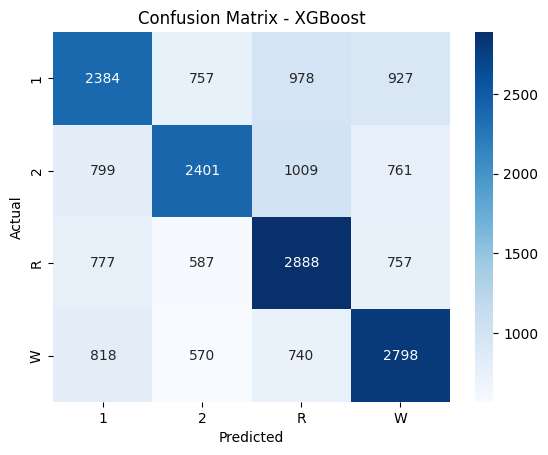

In [5]:
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all feature CSVs ===
output_folder = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\Features_old"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        
        # Parse Patient ID and Side
        parts = file.replace('.csv', '').split('_')
        
        # Example: parts = ['Features', 'P1', 'RW']
        patient_id = parts[1]  # e.g., P1
        side = parts[2]        # e.g., RW
        
        # Add Patient_ID and Side columns
        temp['Patient_ID'] = patient_id
        temp['Side'] = side
        
        features_df = pd.concat([features_df, temp], ignore_index=True)


# === Keep only selected features ===
selected_features = ['EDR_count', 'Storm_mark', 'Epoch_duration', 'Avg_EDA', 'Age (Years)', 'Gender', 'Sleep_stage', 'Patient_ID']
features_df = features_df[selected_features]

# === Preprocessing ===
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')
features_df = features_df.dropna()

# === Split Features and Labels ===
X = features_df.drop(['Sleep_stage', 'Patient_ID'], axis=1)
y = features_df['Sleep_stage']

# === Encode Gender ===
if "Gender" in X.columns:
    gender_le = LabelEncoder()
    X["Gender"] = gender_le.fit_transform(X["Gender"])  # Female -> 0, Male -> 1

# === Encode Labels (y) ===
label_le = LabelEncoder()
y = label_le.fit_transform(y)

# === Resample with SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# === Train XGBoost Classifier ===
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=200,
    max_depth=None,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=1
)

xgb_model.fit(X_train, y_train)

# === Evaluate ===
y_pred = xgb_model.predict(X_test)
y_pred_labels = label_le.inverse_transform(y_pred)
y_test_labels = label_le.inverse_transform(y_test)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

# === Confusion Matrix Plot ===
conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=label_le.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_le.classes_, yticklabels=label_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [3]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, None],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid=param_grid,
    scoring='f1_weighted',  # You can also try 'accuracy'
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(label_le.inverse_transform(y_test), label_le.inverse_transform(y_pred)))


Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:41:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           1       0.51      0.49      0.50      5046
           2       0.56      0.50      0.53      4970
           R       0.53      0.58      0.55      5009
           W       0.54      0.56      0.55      4926

    accuracy                           0.53     19951
   macro avg       0.53      0.53      0.53     19951
weighted avg       0.53      0.53      0.53     19951



In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import glob

# 1. Load and combine all feature files
feature_files = glob.glob(r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\Features\Features_P*.csv")
dfs = []
for file in feature_files:
    df = pd.read_csv(file)
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

# 2. Preprocessing
# Merge 'r' and 'R' REM sleep cases
data['Sleep_stage'] = data['Sleep_stage'].replace({'r': 'R'})

# Select only specified features (B,C,E,F,G) and target (A)
features = ['EDR_count', 'Storm_mark', 'Epoch_duration', 'Avg_EDA', 'Age', 'Gender']
X = data[features]
y = data['Sleep_stage']

# Encode labels and combine N2/N3
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # First encode all classes

# Create mapping for merged classes
class_mapping = {
    'W': 0,
    '1': 1,
    '2': 2,  # Will become 2/3
    '3': 2,  # Merged with N2
    'R': 3   # REM
}
y_merged = y.map(class_mapping)

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_merged, test_size=0.2, random_state=42, stratify=y_merged
)

# 4. Basic XGBoost model
model = XGBClassifier(objective='multi:softmax', num_class=len(class_mapping))
model.fit(X_train, y_train)

# 5. Evaluation with merged classes
y_pred = model.predict(X_test)

# Custom class names for report
class_names = ['W', '1', '2/3', 'R']

print("Classification Report (N2/N3 merged):")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# Feature importance
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(importance)

Classification Report (N2/N3 merged):
              precision    recall  f1-score   support

           W     0.5392    0.3225    0.4036      1473
           1     0.2222    0.0119    0.0225       674
         2/3     0.6373    0.8832    0.7404      5002
           R     0.5251    0.3481    0.4186      2077

    accuracy                         0.6096      9226
   macro avg     0.4809    0.3914    0.3963      9226
weighted avg     0.5661    0.6096    0.5617      9226


Feature Importance:
          Feature  Importance
5          Gender    0.264020
4             Age    0.223834
3         Avg_EDA    0.178859
1      Storm_mark    0.170001
0       EDR_count    0.111823
2  Epoch_duration    0.051463


In [2]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Initialize base model
base_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_mapping),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # Use all cores
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best model after grid search
best_model = grid_search.best_estimator_

# 5. Evaluation with best model
y_pred = best_model.predict(X_test)

print("Best Hyperparameters found:\n", grid_search.best_params_)

print("\nClassification Report (Best Model, N2/N3 merged):")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# Feature importance with best model
importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance (Best Model):")
print(importance)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:09:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters found:
 {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

Classification Report (Best Model, N2/N3 merged):
              precision    recall  f1-score   support

           W     0.5310    0.3313    0.4080      1473
           1     0.2632    0.0148    0.0281       674
         2/3     0.6430    0.8747    0.7411      5002
           R     0.5113    0.3606    0.4229      2077

    accuracy                         0.6094      9226
   macro avg     0.4871    0.3953    0.4000      9226
weighted avg     0.5677    0.6094    0.5642      9226


Feature Importance (Best Model):
          Feature  Importance
5          Gender    0.251569
4             Age    0.219271
3         Avg_EDA    0.181085
1      Storm_mark    0.169942
0       EDR_count    0.112954
2  Epoch_duration    0.065180


iteration 3

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:04:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
               precision    recall  f1-score   support

           1       0.63      0.64      0.64      4816
           2       0.70      0.74      0.72      4817
           R       0.71      0.73      0.72      4839
           W       0.71      0.64      0.67      4842

    accuracy                           0.69     19314
   macro avg       0.69      0.69      0.69     19314
weighted avg       0.69      0.69      0.69     19314



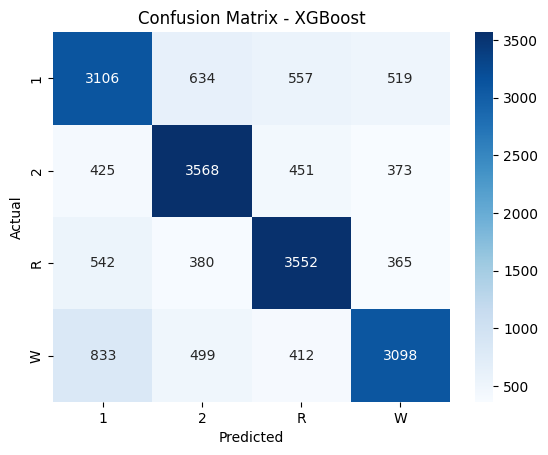

AUC-ROC Score: 0.8939144960523333


In [15]:
import pandas as pd
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# === Load all feature CSVs ===
output_folder = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\New folder\features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

# === Preprocessing ===
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')
features_df = features_df.dropna()

# === Split Features and Labels ===
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str', 'ACC_mean', 'BVP_mean', 'HR_mean', 'TEMP_mean'], axis=1)
y = features_df['Sleep_stage']

# === Encode Gender if present ===
if "Gender" in X.columns:
    gender_le = LabelEncoder()
    X["Gender"] = gender_le.fit_transform(X["Gender"])  # Female -> 0, Male -> 1

# === Encode Labels (y) ===
label_le = LabelEncoder()
y = label_le.fit_transform(y)

# === Resample with SMOTE ===
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',  # Keep eval metric here instead
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    scale_pos_weight=1.5
)

xgb.fit(X_train, y_train, verbose=True)

# === Model Evaluation ===
y_pred = xgb.predict(X_test)

y_pred_labels = label_le.inverse_transform(y_pred)
y_test_labels = label_le.inverse_transform(y_test)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=label_le.classes_)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_le.classes_, yticklabels=label_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

auc_score = roc_auc_score(y_test, xgb.predict_proba(X_test), multi_class='ovr')
print("AUC-ROC Score:", auc_score)
